In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Create Autoencoder for violence and non-violence (same architecture, trained separately)
def create_autoencoder(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the encoder (VGG16) layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Decoder (ensure correct output size: 224x224x3)
    x = base_model.output  # The output from VGG16 will be (7, 7, 512)

    # Decoder starts here: reverse the pooling/downsampling
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (7, 7, 512) to (14, 14, 512)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (14, 14, 256) to (28, 28, 256)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (28, 28, 128) to (56, 56, 128)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (56, 56, 64) to (112, 112, 64)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (112, 112, 32) to (224, 224, 32)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final output shape (224, 224, 3)

    # Create autoencoder model
    autoencoder = Model(base_model.input, decoded)
    return autoencoder

# Compile the autoencoder model
def compile_autoencoder(autoencoder):
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), 
                        loss='mean_squared_error',
                        metrics=['accuracy'])

# Test the model and calculate performance metrics
def test_combined_autoencoders(violence_ae, non_violence_ae, test_generator):
    violence_reconstructions = violence_ae.predict(test_generator)
    non_violence_reconstructions = non_violence_ae.predict(test_generator)
    
    # Compute reconstruction error (Mean Squared Error) for each sample
    violence_errors = np.mean(np.abs(violence_reconstructions - test_generator[0][0]), axis=(1, 2, 3))
    non_violence_errors = np.mean(np.abs(non_violence_reconstructions - test_generator[0][0]), axis=(1, 2, 3))

    # Classify based on which autoencoder has lower reconstruction error
    predictions = np.where(violence_errors < non_violence_errors, 1, 0)  # 1 for violence, 0 for non-violence
    
    # True labels (binary classification task)
    true_labels = np.array([1 if 'violence' in file else 0 for file in test_generator.filenames])

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix: \n{conf_matrix}")

    return accuracy, precision, recall, f1, conf_matrix

# Main function to execute workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'
    input_shape = (224, 224, 3)

    # Create and compile separate autoencoders for violence and non-violence
    violence_ae = create_autoencoder(input_shape)
    non_violence_ae = create_autoencoder(input_shape)
    compile_autoencoder(violence_ae)
    compile_autoencoder(non_violence_ae)

    # Use ImageDataGenerator for data loading and augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=0.3  # 70-30 split for training and testing
    )
    
    batch_size = 32
    
    # Train and validation data generators
    train_generator_violence = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='input',  # For autoencoder, input and target are the same
        subset='training',
        classes=['violence']
    )
    
    train_generator_non_violence = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='input',  # For autoencoder, input and target are the same
        subset='training',
        classes=['non_violence']
    )
    
    # Test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,  # No labels needed for testing
        shuffle=False
    )
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the violence autoencoder
    history_violence = violence_ae.fit(
        train_generator_violence,
        steps_per_epoch=train_generator_violence.samples // batch_size,
        epochs=10,
        callbacks=[early_stopping]
    )

    # Train the non-violence autoencoder
    history_non_violence = non_violence_ae.fit(
        train_generator_non_violence,
        steps_per_epoch=train_generator_non_violence.samples // batch_size,
        epochs=10,
        callbacks=[early_stopping]
    )
    
    # Testing the combined autoencoders
    print("Testing the combined autoencoders...")
    test_accuracy, precision, recall, f1, conf_matrix = test_combined_autoencoders(violence_ae, non_violence_ae, test_generator)

if __name__ == "__main__":
    main()


Found 4090 images belonging to 1 classes.
Found 3662 images belonging to 1 classes.
Found 11073 images belonging to 2 classes.
Epoch 1/15


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.4989 - loss: 0.0683
Epoch 2/15


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 173us/step - accuracy: 0.5345 - loss: 0.0443
Epoch 3/15


c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5500 - loss: 0.0431
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 47us/step - accuracy: 0.6249 - loss: 0.0388
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5771 - loss: 0.0389
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 42us/step - accuracy: 0.6212 - loss: 0.0340
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5722 - loss: 0.0375
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 51us/step - accuracy: 0.5746 - loss: 0.0401
Epoch 9/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5912 - loss: 0.0339
Epoch 10/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 31us/step - accuracy: 0.5859 - loss: 0.0309
Epoch 11/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5887 - loss: 0.0337
Epoch 12/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 0s/step - accuracy: 0.5299 - loss: 0.0352  
Epoch 13/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.5947 - loss: 0.0325
Epoch 14/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 0s/ste

Found 4090 images belonging to 1 classes.
Found 3662 images belonging to 1 classes.
Found 11073 images belonging to 2 classes.
Epoch 1/10


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.4930 - loss: 0.0722
Epoch 2/10


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step - accuracy: 0.4474 - loss: 0.0428
Epoch 3/10


c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


127/127 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.5368 - loss: 0.0437
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 52us/step - accuracy: 0.5253 - loss: 0.0459
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 521s 4s/step - accuracy: 0.5541 - loss: 0.0400
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 0s/step - accuracy: 0.5195 - loss: 0.0369  
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.5640 - loss: 0.0363
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 50us/step - accuracy: 0.5349 - loss: 0.0316
Epoch 9/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.5597 - loss: 0.0352
Epoch 10/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 43us/step - accuracy: 0.5391 - loss: 0.0347
Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.4015 - loss: 0.0648
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 25us/step - accuracy: 0.4024 - loss: 0.0392
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.4317 - loss: 0.0420
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 0s/step - 

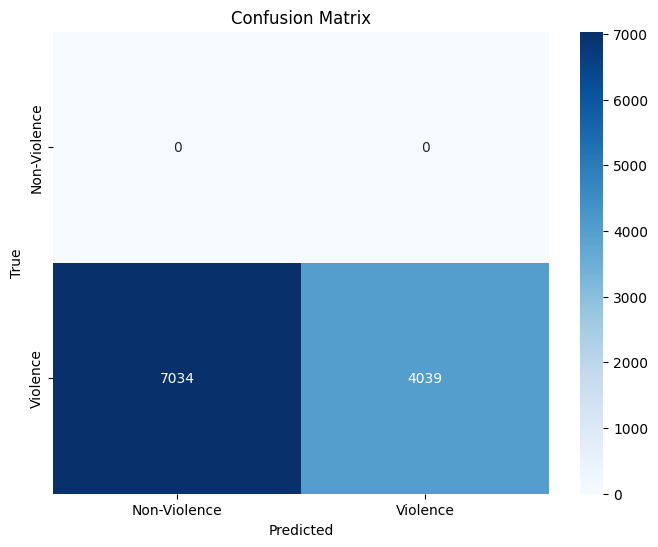

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # For heatmap visualization

# Create Autoencoder for violence and non-violence (same architecture, trained separately)
def create_autoencoder(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the encoder (VGG16) layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Decoder (ensure correct output size: 224x224x3)
    x = base_model.output  # The output from VGG16 will be (7, 7, 512)

    # Decoder starts here: reverse the pooling/downsampling
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (7, 7, 512) to (14, 14, 512)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (14, 14, 256) to (28, 28, 256)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (28, 28, 128) to (56, 56, 128)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (56, 56, 64) to (112, 112, 64)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (112, 112, 32) to (224, 224, 32)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final output shape (224, 224, 3)

    # Create autoencoder model
    autoencoder = Model(base_model.input, decoded)
    return autoencoder

# Compile the autoencoder model
def compile_autoencoder(autoencoder):
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), 
                        loss='mean_squared_error',
                        metrics=['accuracy'])

# Test the model and calculate performance metrics
def test_combined_autoencoders(violence_ae, non_violence_ae, test_generator):
    violence_reconstructions = violence_ae.predict(test_generator)
    non_violence_reconstructions = non_violence_ae.predict(test_generator)
    
    # Compute reconstruction error (Mean Squared Error) for each sample
    violence_errors = np.mean(np.abs(violence_reconstructions - test_generator[0][0]), axis=(1, 2, 3))
    non_violence_errors = np.mean(np.abs(non_violence_reconstructions - test_generator[0][0]), axis=(1, 2, 3))

    # Classify based on which autoencoder has lower reconstruction error
    predictions = np.where(violence_errors < non_violence_errors, 1, 0)  # 1 for violence, 0 for non-violence
    
    # True labels (binary classification task)
    true_labels = np.array([1 if 'violence' in file else 0 for file in test_generator.filenames])

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix: \n{conf_matrix}")

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violence', 'Violence'], yticklabels=['Non-Violence', 'Violence'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1, conf_matrix

# Main function to execute workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'
    input_shape = (224, 224, 3)

    # Create and compile separate autoencoders for violence and non-violence
    violence_ae = create_autoencoder(input_shape)
    non_violence_ae = create_autoencoder(input_shape)
    compile_autoencoder(violence_ae)
    compile_autoencoder(non_violence_ae)

    # Use ImageDataGenerator for data loading and augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=0.3  # 70-30 split for training and testing
    )
    
    batch_size = 32
    
    # Train and validation data generators
    train_generator_violence = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='input',  # For autoencoder, input and target are the same
        subset='training',
        classes=['violence']
    )
    
    train_generator_non_violence = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='input',  # For autoencoder, input and target are the same
        subset='training',
        classes=['non_violence']
    )
    
    # Test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,  # No labels needed for testing
        shuffle=False
    )
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the violence autoencoder
    history_violence = violence_ae.fit(
        train_generator_violence,
        steps_per_epoch=train_generator_violence.samples // batch_size,
        epochs=10,
        callbacks=[early_stopping]
    )

    # Train the non-violence autoencoder
    history_non_violence = non_violence_ae.fit(
        train_generator_non_violence,
        steps_per_epoch=train_generator_non_violence.samples // batch_size,
        epochs=10,
        callbacks=[early_stopping]
    )
    
    # Testing the combined autoencoders
    print("Testing the combined autoencoders...")
    test_accuracy, precision, recall, f1, conf_matrix = test_combined_autoencoders(violence_ae, non_violence_ae, test_generator)

if __name__ == "__main__":
    main()
